# TP MODELISATION DU CHURN

# Sommaire

1. [Import de la table préparée et Séparation Train / Test](#sect1)
2. [Standardisation des variables](#sect2)
3. [Modélisation](#sectmodel)
  - [Régression pénalisée](#sect41)
  - [Random Forest](#sect43)
  - [GBM (Gradient Boosting Machine)](#sect44)

In [3]:
import pandas as pd
import os
import numpy as np
import pickle
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score,roc_auc_score,roc_curve,auc

import matplotlib.pyplot as plt

# 1 Chargement des données préparées <a name="sect1" ></a>

In [4]:
repertoire = "../data"
os.chdir(repertoire)
file=open("churn_prepared.pydata","rb")
data=pickle.load(file)
file.close()

In [5]:
data.shape

(3333, 21)

In [6]:
data.describe()


,churnMoy_state,Account Length,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,0.145772,101.064806,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,0.061771,39.822106,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,0.035714,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,0.095238,74.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,0.130435,101.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,0.193548,127.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,0.289474,243.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [7]:
data.dtypes

churnMoy_state    float64
Account Length      int64
Int'l Plan           bool
VMail Plan           bool
VMail Message       int64
Day Mins          float64
Day Calls           int64
Day Charge        float64
Eve Mins          float64
Eve Calls           int64
Eve Charge        float64
Night Mins        float64
Night Calls         int64
Night Charge      float64
Intl Mins         float64
Intl Calls          int64
Intl Charge       float64
CustServ Calls      int64
Churn?             object
Area Code_415        bool
Area Code_510        bool
dtype: object

In [8]:
X= data.drop('Churn?',axis=1)
y=data['Churn?'].astype(int)

In [9]:
y.value_counts(normalize=True)

Churn?
0    0.855086
1    0.144914
Name: proportion, dtype: float64

In [10]:
# split Apprentissage Test
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size=0.3,random_state=42)

In [11]:
X_train.shape, X_test.shape

((2333, 20), (1000, 20))

In [12]:
y_train.sum(), y_test.sum()

(np.int64(338), np.int64(145))

In [13]:
y_train.mean(), y_test.mean()

(np.float64(0.14487783969138449), np.float64(0.145))

# 2. Standardisation des variables <a name="sect2" ></a>

In [14]:
from sklearn.preprocessing import StandardScaler
norm=StandardScaler().fit(X_train) 
X_train = pd.DataFrame(norm.transform(X_train), columns=X.columns)
X_test = pd.DataFrame(norm.transform(X_test), columns=X.columns)

In [15]:
X_train.describe()

,churnMoy_state,Account Length,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Area Code_415,Area Code_510
count,2.333000e+03,2.333000e+03,2.333000e+03,2.333000e+03,2.333000e+03,2.333000e+03,2.333000e+03,2.333000e+03,2.333000e+03,2.333000e+03,2.333000e+03,2.333000e+03,2.333000e+03,2.333000e+03,2.333000e+03,2.333000e+03,2.333000e+03,2.333000e+03,2.333000e+03,2.333000e+03
mean,-1.903511e-16,-1.614178e-16,3.350180e-17,3.350180e-17,8.527731e-17,-2.664916e-16,-2.215687e-16,-5.710534e-16,1.964424e-16,3.220741e-16,-3.136987e-16,-9.593697e-17,-7.614046e-18,7.279028e-16,-2.010108e-16,-9.136855e-17,3.959304e-16,-5.482113e-17,4.187725e-18,-2.131933e-17
std,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00
min,-1.784019e+00,-2.487259e+00,-3.186077e-01,-6.287567e-01,-6.014372e-01,-3.331687e+00,-5.004624e+00,-3.331755e+00,-3.942555e+00,-4.997841e+00,-3.942646e+00,-3.557234e+00,-3.436090e+00,-3.558946e+00,-3.601369e+00,-1.856517e+00,-3.601979e+00,-1.202826e+00,-1.006450e+00,-5.679457e-01
25%,-8.153774e-01,-6.634062e-01,-3.186077e-01,-6.287567e-01,-6.014372e-01,-6.710391e-01,-6.624940e-01,-6.705548e-01,-6.949818e-01,-6.613366e-01,-6.953804e-01,-6.760070e-01,-6.688108e-01,-6.742155e-01,-6.451014e-01,-6.183081e-01,-6.431349e-01,-4.329515e-01,-1.006450e+00,-5.679457e-01
50%,-2.426155e-01,-1.381472e-02,-3.186077e-01,-6.287567e-01,-6.014372e-01,-7.267824e-03,3.623950e-02,-7.435909e-03,1.952346e-02,-1.335321e-02,1.855747e-02,-7.867457e-03,-2.613915e-03,-9.880450e-03,2.357809e-02,-2.055720e-01,2.162742e-02,-4.329515e-01,9.935910e-01,-5.679457e-01
75%,7.844434e-01,6.607610e-01,-3.186077e-01,1.590440e+00,8.570659e-01,6.713363e-01,6.850635e-01,6.709521e-01,6.576843e-01,6.844750e-01,6.587986e-01,6.662914e-01,6.635829e-01,6.678305e-01,6.570640e-01,6.199004e-01,6.603206e-01,3.369234e-01,9.935910e-01,-5.679457e-01
max,2.345453e+00,3.558938e+00,3.138656e+00,1.590440e+00,3.117746e+00,3.172530e+00,3.230450e+00,3.172917e+00,3.177049e+00,3.475788e+00,3.176005e+00,3.902655e+00,3.840829e+00,3.900333e+00,3.437363e+00,5.572734e+00,3.436681e+00,5.726047e+00,9.935910e-01,1.760732e+00


In [16]:
X_test.describe()

,churnMoy_state,Account Length,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Area Code_415,Area Code_510
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.023222,0.042625,0.054777,-0.049546,-0.036048,0.005136,0.026906,0.005136,-0.027554,-0.025515,-0.027542,0.025407,0.009685,0.025508,0.005031,-0.025619,0.005100,0.001258,-0.044430,0.063126
std,1.017102,0.982330,1.073604,0.975114,0.993613,1.032593,1.005203,1.032595,0.975330,0.976362,0.975363,1.048096,1.009313,1.048094,0.940531,1.051659,0.940386,1.041961,0.999798,1.035559
min,-1.784019,-2.487259,-0.318608,-0.628757,-0.601437,-3.331687,-5.004624,-3.331755,-3.000974,-2.854511,-3.000709,-3.145916,-3.179860,-3.144294,-3.601369,-1.856517,-3.601979,-1.202826,-1.006450,-0.567946
25%,-0.885824,-0.638422,-0.318608,-0.628757,-0.601437,-0.652498,-0.612584,-0.652832,-0.669534,-0.661337,-0.670047,-0.647415,-0.668811,-0.648578,-0.574714,-0.618308,-0.577962,-0.432951,-1.006450,-0.567946
50%,-0.120628,0.011170,-0.318608,-0.628757,-0.601437,0.012200,0.036240,0.012196,-0.033330,-0.013353,-0.034412,0.060351,-0.002614,0.061458,0.058772,-0.205572,0.060731,-0.432951,-1.006450,-0.567946
75%,0.810050,0.685745,-0.318608,1.590440,0.565365,0.720470,0.685063,0.720850,0.679707,0.634630,0.680102,0.793699,0.714829,0.793787,0.657064,0.619900,0.660321,0.336923,0.993591,1.760732
max,2.345453,3.084237,3.138656,1.590440,3.044821,3.098366,3.130631,3.098752,3.139856,3.176719,3.139157,3.639814,3.277124,3.641733,2.733490,6.398207,2.732815,5.726047,0.993591,1.760732


# 3. Modélisation <a name="sectmodel" ></a>

In [ ]:
# Import de la fonction de lift à utiliser
os.chdir('../modules/')
from fonctions_metrics import lift

FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: '/home/jupyter/python_ml/modules/'

## 3.1 PARAMETRER LE MODELE REG PENALISEE <a name="sect41" ></a>
Choisir ridge (L2) ou lasso (L1) ou elasticnet, avec la classe LogisticRegression
Définir une grille d'hyper param pour C
et utliser GridSearchCV pour la balayer

In [ ]:
## Regression logistique avec pénalité lasso et grid search
#### on cherche par CV le meilleur C (1/alpha) le coef de regularisation

In [ ]:
param = [{"C":[0.001,0.005,0.01,0.025,0.05,0.075,0.1], "class_weight":["balanced",None]}]
# Instancie le modele LASSO : construction classe
lr=LogisticRegression(penalty='l1',solver='liblinear')
# Grid Search : on indique le modele et la grille de param
modeleLassoCV = GridSearchCV (lr,param,cv = 4,n_jobs=-1,scoring='roc_auc', refit=True)
modeleLassoCV = modeleLassoCV.fit(X_train,y_train)
modeleLassoCV.best_params_

{'C': 0.05, 'class_weight': None}

In [ ]:
modeleLassoCV.best_params_['C']

0.05

In [ ]:
pd.DataFrame(modeleLassoCV.cv_results_).sort_values(['rank_test_score'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
9,0.024185,0.011653,0.002499,0.000268,0.05,None,"{'C': 0.05, 'class_weight': None}",0.807238,0.823122,0.832379,0.839310,0.825512,0.012012,1
8,0.057145,0.010399,0.002479,0.000099,0.05,balanced,"{'C': 0.05, 'class_weight': 'balanced'}",0.808157,0.821572,0.834049,0.837586,0.825341,0.011568,2
11,0.069322,0.028623,0.002368,0.000159,0.075,None,"{'C': 0.075, 'class_weight': None}",0.808605,0.825413,0.828586,0.838223,0.825207,0.010683,3
10,0.118215,0.094887,0.002509,0.000242,0.075,balanced,"{'C': 0.075, 'class_weight': 'balanced'}",0.808417,0.822526,0.832474,0.836570,0.824997,0.010850,4
12,0.117791,0.140346,0.002643,0.000350,0.1,balanced,"{'C': 0.1, 'class_weight': 'balanced'}",0.808818,0.822955,0.831854,0.835719,0.824837,0.010342,5
13,0.039396,0.021964,0.002216,0.000136,0.1,None,"{'C': 0.1, 'class_weight': None}",0.808936,0.826128,0.826510,0.836830,0.824601,0.010012,6
6,0.015480,0.012403,0.002491,0.000196,0.025,balanced,"{'C': 0.025, 'class_weight': 'balanced'}",0.805328,0.816848,0.835791,0.838129,0.824024,0.013587,7
7,0.004139,0.000171,0.002304,0.000062,0.025,None,"{'C': 0.025, 'class_weight': None}",0.798915,0.808426,0.834121,0.830357,0.817955,0.014735,8
4,0.013523,0.014913,0.002442,0.000246,0.01,balanced,"{'C': 0.01, 'class_weight': 'balanced'}",0.781351,0.798764,0.829802,0.818261,0.807045,0.018523,9
2,0.004580,0.000675,0.002381,0.000061,0.005,balanced,"{'C': 0.005, 'class_weight': 'balanced'}",0.779925,0.768656,0.816407,0.741094,0.776520,0.027016,10


In [ ]:
# appliquer la méthode fit() : apprend sur les données de TRAIN
modeleLassoCV.fit(X_train,y_train)

GridSearchCV(cv=4,
             estimator=LogisticRegression(penalty='l1', solver='liblinear'),
             n_jobs=-1,
             param_grid=[{'C': [0.001, 0.005, 0.01, 0.025, 0.05, 0.075, 0.1],
                          'class_weight': ['balanced', None]}],
             scoring='roc_auc')

In [ ]:
# Visualisation des coefficients estimées pour chaque variable
coef=list(modeleLassoCV.best_estimator_.coef_[0])
coef_df = pd.DataFrame({'Coefficients': list(coef)}, list(X_train.columns.values))
coef_df.sort_values(['Coefficients'], ascending=False)

,Coefficients
CustServ Calls,0.536147
Int'l Plan,0.495770
Day Mins,0.464819
churnMoy_state,0.286577
Eve Charge,0.162173
Intl Charge,0.126218
Eve Mins,0.058522
Night Charge,0.034023
Day Charge,0.010360
VMail Message,0.000000


In [ ]:
# combien d'élemnts non nuls ?
feature_0= [i for i in coef if i==0] #print(feature_0)
print(len(feature_0))
# PLus on baisse C, plus de colonnes s'annulent (0)

9


### Analyser les résultats et les performances 

In [ ]:
# Prediction des probabilités de 1 avec 
# Colonne 1 signifie la seconde modalité du vecteur soit la proba Churn=1
probas_test = modeleLassoCV.predict_proba(X_test)[:,1]
probas_train = modeleLassoCV.predict_proba(X_train)[:,1]

In [ ]:
# score: accuracy taux de bien classé global au cutoff de 0.5
print(modeleLassoCV.score(X_test, y_test))
print(modeleLassoCV.score(X_train,y_train))

0.8212623512805
0.8303139505568656


In [ ]:
#AUC
print(roc_auc_score(y_train,probas_train))
print(roc_auc_score(y_test,probas_test))

0.8303139505568656
0.8212623512805


In [ ]:
print(lift(probas_train,X_train,y_train))
print(lift(probas_test,X_test,y_test))

# Le lift à 10% : je prend les 10% plus fortes proba de churn (individus les plus risqués),
# taux de churn / taux de churn moyen 

lift at 10 percent : 3.58
3.58
lift at 10 percent : 3.72
3.72


In [ ]:
#compute lift at 5%
print(lift(probas_train,X_train,y_train,p=5))
print(lift(probas_test,X_test,y_test,p=5))

lift at 5 percent : 3.96
3.96
lift at 5 percent : 4.41
4.41


In [ ]:
# ENR LES RESULTATS DANS UN DICTIONNAIRE POUR POUVOIR COMPARER
model='Score Lasso'
# métriques (liste de dictionnaires)
metriques = [{'model':model,'AUC_test':round(roc_auc_score(y_test,probas_test),3),'lift at 5':lift(probas_test,X_test,y_test,p=5),'lift at 10':lift(probas_test,X_test,y_test,p=10)}]
metriques

lift at 5 percent : 4.41
lift at 10 percent : 3.72


[{'model': 'Score Lasso',
  'AUC_test': 0.821,
  'lift at 5': 4.41,
  'lift at 10': 3.72}]

In [ ]:
# mat de confusion à un cutoff donné
target_names = ['Fidèles','Churners']

# métriques au cutoff donné
print(classification_report(y_train,modeleLassoCV.predict(X_train)), target_names=target_names))
# métriques au cutoff par défaut
print(classification_report(y_test,modeleLassoCV.predict(X_test), target_names=target_names))



              precision    recall  f1-score   support

     Fidèles       0.87      0.98      0.92      1995
    Churners       0.59      0.14      0.23       338

    accuracy                           0.86      2333
   macro avg       0.73      0.56      0.58      2333
weighted avg       0.83      0.86      0.82      2333

              precision    recall  f1-score   support

     Fidèles       0.88      0.98      0.93       855
    Churners       0.63      0.20      0.30       145

    accuracy                           0.87      1000
   macro avg       0.75      0.59      0.62      1000
weighted avg       0.84      0.87      0.84      1000



In [ ]:
from fonctions_metrics import CAP_table, auc_et_roc
CAP_table(pd.Series(probas_test, index= y_test.index),y_test, stepsize=5,n=10 )

,Population,Positifs parmi la population,% positifs,Population cumulée,Positifs cumulés,% Positifs cumulés,% positifs cumulés sur le total des positifs,Lift
5,50,32,64.0,50,32,64.00,22.07,4.41
10,50,22,44.0,100,54,54.00,37.24,3.72
15,50,17,34.0,150,71,47.33,48.97,3.26
20,50,12,24.0,200,83,41.50,57.24,2.86
25,50,13,26.0,250,96,38.40,66.21,2.65
30,50,12,24.0,300,108,36.00,74.48,2.48
35,50,5,10.0,350,113,32.29,77.93,2.23
40,50,3,6.0,400,116,29.00,80.00,2.00
45,50,3,6.0,450,119,26.44,82.07,1.82
50,50,5,10.0,500,124,24.80,85.52,1.71


auc= 0.8303213655440376


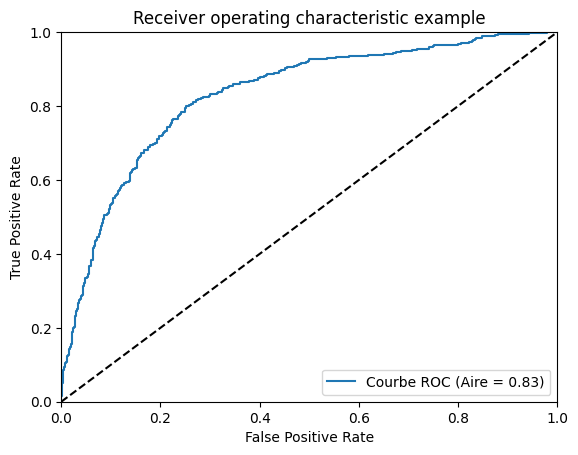

In [ ]:
auc_et_roc(y_train, probas_train)

auc= 0.8212542851381328


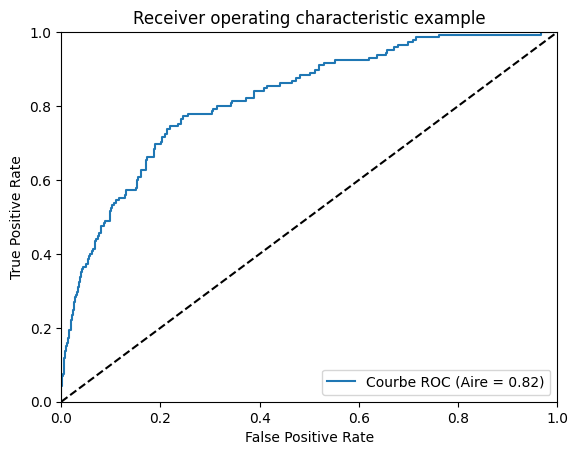

In [ ]:
auc_et_roc(y_test, probas_test)

#### Sauvegarde du modèle en pickle

In [ ]:
with open("/home/jupyter/python_ml/data/my_churn_model.pkl", "wb") as file:
    pickle.dump(modeleLassoCV, file)

In [ ]:
# Test de réapplication
with open("/home/jupyter/python_ml/data/my_churn_model.pkl", "rb") as file:
    test_reapp_model = pickle.load(file)

In [ ]:
test_reapp_model.predict_proba(X_test.head(5))

array([[0.87234743, 0.12765257],
       [0.53946871, 0.46053129],
       [0.92534152, 0.07465848],
       [0.77322578, 0.22677422],
       [0.82699987, 0.17300013]])

## 3.2 PARAMETRER LE MODELE RANDOMFOREST <a name="sect43" ></a>
Tester un modle light peu profond et un modele complexe

In [ ]:
# exemple randomforest avec des rbres peu profonds
rf_light = RandomForestClassifier(                                                                       
                                       n_jobs = -1, # coeurs
                                       random_state = 42
                                     )    

param = [{"n_estimators":[100,200,300], "class_weight":["balanced",None], "max_depth":[3,4,5],"min_samples_split":[0.05,0.1]}]

# Grid Search : on indique le modele et la grille de param
modelerfCV = GridSearchCV (rf_light,param,cv = 4,n_jobs=-1,scoring='roc_auc', refit=True)
modelerfCV = modelerfCV.fit(X_train,y_train)
modelerfCV.best_params_

{'class_weight': 'balanced',
 'max_depth': 5,
 'min_samples_split': 0.05,
 'n_estimators': 300}

In [ ]:
pd.DataFrame(modelerfCV.cv_results_).sort_values(['rank_test_score'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
14,0.899506,0.027708,0.052135,0.007523,balanced,5,0.05,300,"{'class_weight': 'balanced', 'max_depth': 5, '...",0.877543,0.899943,0.913136,0.905150,0.898943,0.013218,1
13,0.596459,0.021787,0.036033,0.006379,balanced,5,0.05,200,"{'class_weight': 'balanced', 'max_depth': 5, '...",0.876600,0.899776,0.908841,0.906922,0.898035,0.012828,2
12,0.293916,0.002326,0.018184,0.000200,balanced,5,0.05,100,"{'class_weight': 'balanced', 'max_depth': 5, '...",0.878038,0.897247,0.908102,0.907489,0.897719,0.012153,3
8,1.180525,0.167324,0.066958,0.038202,balanced,4,0.05,300,"{'class_weight': 'balanced', 'max_depth': 4, '...",0.869315,0.896364,0.906933,0.902977,0.893897,0.014686,4
7,1.164979,0.037740,0.070840,0.001397,balanced,4,0.05,200,"{'class_weight': 'balanced', 'max_depth': 4, '...",0.868301,0.894933,0.902543,0.901228,0.891751,0.013841,5
6,0.432391,0.151442,0.030869,0.009869,balanced,4,0.05,100,"{'class_weight': 'balanced', 'max_depth': 4, '...",0.868136,0.893215,0.900611,0.898937,0.890225,0.013044,6
32,0.887582,0.020521,0.045070,0.000548,None,5,0.05,300,"{'class_weight': None, 'max_depth': 5, 'min_sa...",0.856820,0.899370,0.901207,0.903024,0.890105,0.019261,7
31,0.588661,0.004563,0.031523,0.000619,None,5,0.05,200,"{'class_weight': None, 'max_depth': 5, 'min_sa...",0.857668,0.899561,0.901851,0.901134,0.890054,0.018716,8
30,0.292381,0.000789,0.017824,0.000119,None,5,0.05,100,"{'class_weight': None, 'max_depth': 5, 'min_sa...",0.860592,0.902281,0.899418,0.897023,0.889828,0.016982,9
25,0.529601,0.002472,0.030313,0.000108,None,4,0.05,200,"{'class_weight': None, 'max_depth': 4, 'min_sa...",0.854698,0.897318,0.900658,0.903520,0.889049,0.019954,10


In [ ]:
# Importance des variables Light
df=pd.DataFrame(modelerfCV.best_estimator_.feature_importances_,X_train.columns.values)
df.columns=['Importance']
df.sort_values(by='Importance',ascending=False)

,Importance
CustServ Calls,0.213725
Day Mins,0.195042
Day Charge,0.172858
Int'l Plan,0.141700
churnMoy_state,0.043489
Eve Charge,0.033615
VMail Message,0.031879
Eve Mins,0.031296
VMail Plan,0.022672
Intl Charge,0.020165


### Analyser les résultats et les performances (light)

In [ ]:
# Prediction des probabilités de 1 ( array2d ) avec fonction predict_proba
probas_test = modelerfCV.predict_proba(X_test)[:,1]
probas_train = modelerfCV.predict_proba(X_train)[:,1]

In [ ]:
#AUC sur train et test avec roc_auc_score
print(roc_auc_score(y_train,probas_train))
print(roc_auc_score(y_test,probas_test))
# un peu de surapprentissage mais peu ce qui est normal car ce sont des arbres peu profonds

0.938589076240898
0.8870094777172818


In [ ]:
print(lift(probas_train,X_train,y_train))
print(lift(probas_test,X_test,y_test))

lift at 10 percent : 5.89
5.89
lift at 10 percent : 5.1
5.1


In [ ]:
print(classification_report(y_train,modelerfCV.predict(X_train), target_names=target_names))
print(classification_report(y_test,modelerfCV.predict(X_test), target_names=target_names))

              precision    recall  f1-score   support

     Fidèles       0.97      0.87      0.92      1995
    Churners       0.53      0.86      0.65       338

    accuracy                           0.87      2333
   macro avg       0.75      0.86      0.79      2333
weighted avg       0.91      0.87      0.88      2333

              precision    recall  f1-score   support

     Fidèles       0.97      0.83      0.89       855
    Churners       0.45      0.84      0.59       145

    accuracy                           0.83      1000
   macro avg       0.71      0.83      0.74      1000
weighted avg       0.89      0.83      0.85      1000



In [ ]:
# AJOUTE LES RESULTATS
model='rf'
# métriques (liste de dictionnaires)
metriques.append([{'model':model,'AUC_test':round(roc_auc_score(y_test,probas_test),3),'lift at 5':lift(probas_test,X_test,y_test,p=5),'lift at 10':lift(probas_test,X_test,y_test,p=10)}])
metriques

lift at 5 percent : 6.07
lift at 10 percent : 5.1


[{'model': 'Score Lasso',
  'AUC_test': 0.821,
  'lift at 5': 4.41,
  'lift at 10': 3.72},
 [{'model': 'rf', 'AUC_test': 0.887, 'lift at 5': 6.07, 'lift at 10': 5.1}]]

## 3.4 PARAMETRER LE MODELE GRADIENT BOOSTING MACHINE <a name="sect44" ></a>


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gbt_noRand05=GradientBoostingClassifier(
                                       random_state=42)

param = [{"n_estimators":[100,200,300], "max_depth":[2,3],"subsample":[0.9,1.0], "learning_rate":[0.001,0.01,0.05]}]

# Grid Search : on indique le modele et la grille de param
modelegbmCV = GridSearchCV (gbt_noRand05,param,cv = 4,n_jobs=-1,scoring='roc_auc', refit=True)
modelegbmCV = modelegbmCV.fit(X_train,y_train)
modelegbmCV.best_params_

{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.9}

In [ ]:
pd.DataFrame(modelegbmCV.cv_results_).sort_values(['rank_test_score'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
34,2.536817,0.704885,0.007232,0.001807,0.05,3,300,0.9,"{'learning_rate': 0.05, 'max_depth': 3, 'n_est...",0.904609,0.925589,0.939116,0.934207,0.925881,0.013201,1
32,1.230279,0.005929,0.005294,0.000049,0.05,3,200,0.9,"{'learning_rate': 0.05, 'max_depth': 3, 'n_est...",0.899611,0.919935,0.939737,0.932837,0.923030,0.015275,2
30,0.625567,0.016681,0.005491,0.002189,0.05,3,100,0.9,"{'learning_rate': 0.05, 'max_depth': 3, 'n_est...",0.900589,0.918623,0.943673,0.927238,0.922531,0.015539,3
35,1.960021,0.019134,0.006031,0.000066,0.05,3,300,1.0,"{'learning_rate': 0.05, 'max_depth': 3, 'n_est...",0.901285,0.916213,0.936850,0.931703,0.921513,0.013931,4
33,1.296593,0.006391,0.005188,0.000082,0.05,3,200,1.0,"{'learning_rate': 0.05, 'max_depth': 3, 'n_est...",0.895862,0.917860,0.938615,0.930097,0.920609,0.016080,5
31,1.021866,0.362605,0.005660,0.001210,0.05,3,100,1.0,"{'learning_rate': 0.05, 'max_depth': 3, 'n_est...",0.890864,0.917347,0.939904,0.922549,0.917666,0.017584,6
28,1.285362,0.003246,0.005360,0.000129,0.05,2,300,0.9,"{'learning_rate': 0.05, 'max_depth': 2, 'n_est...",0.895296,0.914710,0.931649,0.927900,0.917389,0.014222,7
22,2.284713,0.787898,0.005788,0.000073,0.01,3,300,0.9,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.891064,0.917752,0.938043,0.919880,0.916685,0.016762,8
23,1.972830,0.037775,0.005683,0.000061,0.01,3,300,1.0,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.892856,0.917812,0.932222,0.916466,0.914839,0.014115,9
29,1.334809,0.005904,0.005321,0.000052,0.05,2,300,1.0,"{'learning_rate': 0.05, 'max_depth': 2, 'n_est...",0.894023,0.913040,0.932007,0.920057,0.914782,0.013770,10


Analyse du nb iterations optimal en affichant la fonction de perte sur le test

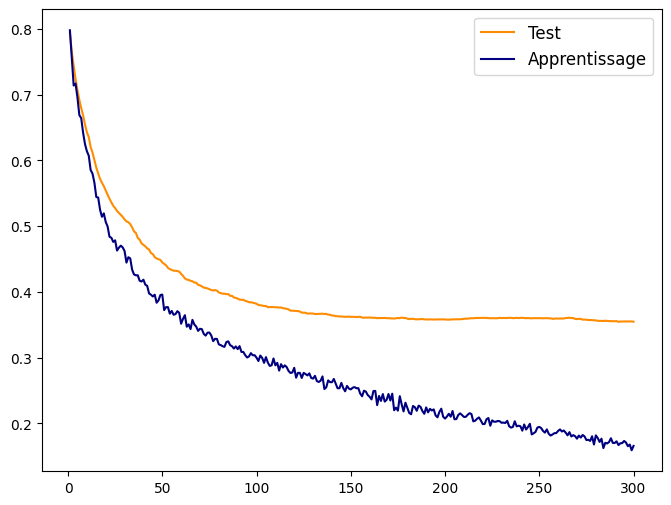

In [ ]:
niter=modelegbmCV.best_estimator_.n_estimators
iter = np.arange(niter) + 1
test_deviance = np.zeros((niter,), dtype=np.float64)
# staged_decision_functio : décision fonction à chaque iteration
for i, y_pred in enumerate(modelegbmCV.best_estimator_.staged_decision_function(X_test)):
    # clf.loss_ assumes that y_test[i] in {0, 1}
    test_deviance[i] = modelegbmCV.best_estimator_.loss_(y_test, y_pred)

plt.figure(figsize=(8, 6))
# Erreur sur le test (evolution deviance)
plt.plot(iter,test_deviance,label='Test',color='darkorange')
        # min vers 100 
# Erreur sur apprentissage (evolution deviance)
plt.plot(iter,modelegbmCV.best_estimator_.train_score_,label='Apprentissage',color='navy')    
# Diminution de l'erreur rapport modele precedant (par rapport au oob)
#plt.plot(iter,gbt_noRand05.oob_improvement_)
plt.legend(loc="upper right", fontsize=12)


In [ ]:
# Algo avc les mêmes params sauf itértionq qu'on met à 100
gbt_Rand=GradientBoostingClassifier(**modelegbmCV.best_params_)
gbt_Rand.n_estimators = 100
# Apprentissage du modele
gbt_Rand.fit(X_train,y_train)
gbt_Rand

GradientBoostingClassifier(learning_rate=0.05, subsample=0.9)

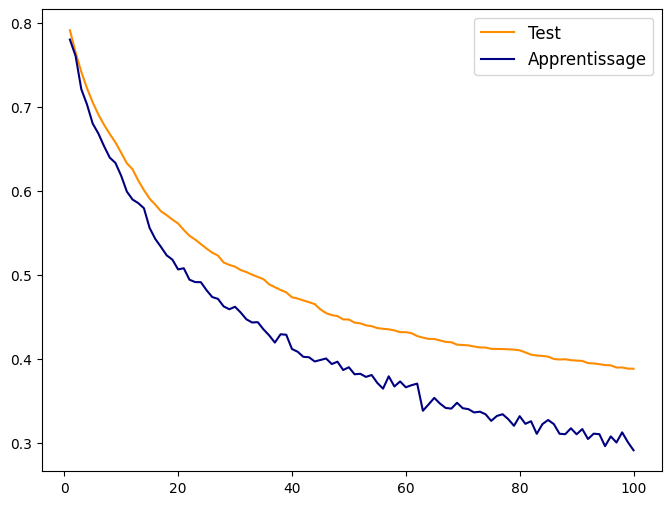

In [ ]:
niter=gbt_Rand.n_estimators
iter = np.arange(niter) + 1
test_deviance = np.zeros((niter,), dtype=np.float64)
# staged_decision_functio : décision fonction à chaque iteration
for i, y_pred in enumerate(gbt_Rand.staged_decision_function(X_test)):
    # clf.loss_ assumes that y_test[i] in {0, 1}
    test_deviance[i] = gbt_Rand.loss_(y_test, y_pred)

plt.figure(figsize=(8, 6))
# Erreur sur le test (evolution deviance)
plt.plot(iter,test_deviance,label='Test',color='darkorange')
        # min vers 100 
# Erreur sur apprentissage (evolution deviance)
plt.plot(iter,gbt_Rand.train_score_,label='Apprentissage',color='navy')    
# Diminution de l'erreur rapport modele precedant (par rapport au oob)
#plt.plot(iter,gbt_noRand05.oob_improvement_)
plt.legend(loc="upper right", fontsize=12)

### Analyser les résultats et les performances (light) 

In [ ]:
# Prediction des probabilités de 1 , array2d
probas_test = modelegbmCV.predict_proba(X_test)[:,1]
probas_train = modelegbmCV.predict_proba(X_train)[:,1]


In [ ]:
print(roc_auc_score(y_train,probas_train))
print(roc_auc_score(y_test,probas_test))


0.9915558126084442
0.9037870538415004


In [ ]:
print(classification_report(y_train,modelegbmCV.predict(X_train), target_names=target_names))
print(classification_report(y_test,modelegbmCV.predict(X_test), target_names=target_names))

              precision    recall  f1-score   support

     Fidèles       0.98      1.00      0.99      1995
    Churners       0.99      0.88      0.93       338

    accuracy                           0.98      2333
   macro avg       0.99      0.94      0.96      2333
weighted avg       0.98      0.98      0.98      2333

              precision    recall  f1-score   support

     Fidèles       0.96      0.99      0.97       855
    Churners       0.92      0.75      0.83       145

    accuracy                           0.95      1000
   macro avg       0.94      0.87      0.90      1000
weighted avg       0.95      0.95      0.95      1000



In [ ]:
# AJOUTE LES RESULTATS
model='gbm heavy'
# métriques (liste de dictionnaires)
metriques.append([{'model':model,'AUC_test':round(roc_auc_score(y_test,probas_test),3),'lift at 5':lift(probas_test,X_test,y_test,p=5),'lift at 10':lift(probas_test,X_test,y_test,p=10)}])
metriques
# conclusion  le modele RF est plus predictif mais moins confiance dans sa capacité à etre robuste à moyen terme


lift at 5 percent : 6.9
lift at 10 percent : 6.55


[{'model': 'Score Lasso',
  'AUC_test': 0.821,
  'lift at 5': 4.41,
  'lift at 10': 3.72},
 [{'model': 'rf', 'AUC_test': 0.887, 'lift at 5': 6.07, 'lift at 10': 5.1}],
 [{'model': 'gbm heavy',
   'AUC_test': 0.904,
   'lift at 5': 6.9,
   'lift at 10': 6.55}]]

In [ ]:
# Prediction des probabilités de 1 , array2d
probas_test = gbt_Rand.predict_proba(X_test)[:,1]
probas_train = gbt_Rand.predict_proba(X_train)[:,1]


In [ ]:
print(roc_auc_score(y_train,probas_train))
print(roc_auc_score(y_test,probas_test))


0.9507466892082277
0.9048800161322847


In [ ]:
print(classification_report(y_train,gbt_Rand.predict(X_train), target_names=target_names))
print(classification_report(y_test,gbt_Rand.predict(X_test), target_names=target_names))

              precision    recall  f1-score   support

     Fidèles       0.97      1.00      0.98      1995
    Churners       0.98      0.79      0.88       338

    accuracy                           0.97      2333
   macro avg       0.97      0.90      0.93      2333
weighted avg       0.97      0.97      0.97      2333

              precision    recall  f1-score   support

     Fidèles       0.95      0.99      0.97       855
    Churners       0.92      0.68      0.78       145

    accuracy                           0.94      1000
   macro avg       0.93      0.83      0.87      1000
weighted avg       0.94      0.94      0.94      1000



In [ ]:
# AJOUTE LES RESULTATS
model='gbm light'
# métriques (liste de dictionnaires)
metriques.append([{'model':model,'AUC_test':round(roc_auc_score(y_test,probas_test),3),'lift at 5':lift(probas_test,X_test,y_test,p=5),'lift at 10':lift(probas_test,X_test,y_test,p=10)}])
metriques
# conclusion  le modele RF est plus predictif mais moins confiance dans sa capacité à etre robuste à moyen terme


lift at 5 percent : 6.76
lift at 10 percent : 6.41


[{'model': 'Score Lasso',
  'AUC_test': 0.821,
  'lift at 5': 4.41,
  'lift at 10': 3.72},
 [{'model': 'rf', 'AUC_test': 0.887, 'lift at 5': 6.07, 'lift at 10': 5.1}],
 [{'model': 'gbm heavy',
   'AUC_test': 0.904,
   'lift at 5': 6.9,
   'lift at 10': 6.55}],
 [{'model': 'gbm light',
   'AUC_test': 0.905,
   'lift at 5': 6.76,
   'lift at 10': 6.41}]]

# 4. Comparaison et conclusion 

In [ ]:
metriques

[{'model': 'Score Lasso',
  'AUC_test': 0.821,
  'lift at 5': 4.41,
  'lift at 10': 3.72},
 [{'model': 'rf', 'AUC_test': 0.887, 'lift at 5': 6.07, 'lift at 10': 5.1}],
 [{'model': 'gbm heavy',
   'AUC_test': 0.904,
   'lift at 5': 6.9,
   'lift at 10': 6.55}],
 [{'model': 'gbm light',
   'AUC_test': 0.905,
   'lift at 5': 6.76,
   'lift at 10': 6.41}]]